<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/LTV_(Lifetime_Value)_Tahminleme_Projesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

. LTV (Lifetime Value) Tahminleme Projesi
Amaç: Bir mobil uygulama kullanıcısının toplamda ne kadar gelir getireceğini tahmin etmek.
•	Veri: Kullanıcıların kayıt tarihi, uygulama içi harcamalar, oturum süresi, son giriş tarihi gibi bilgiler.
•	Yöntem:
o	Cohort analizi
o	RFM analizi
o	Regresyon modelleri (XGBoost, LightGBM, Linear Regression)
•	Araçlar: Python, Pandas, Scikit-learn, Matplotlib, Seaborn

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm lifetimes

2. Veri Yükleme ve Keşifçi Veri Analizi


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Örnek veri yükleme (gerçek projede kendi verinizi yükleyeceksiniz)
# Burada örnek veri oluşturalım
np.random.seed(42)
n_users = 1000
data = {
    'user_id': np.arange(1, n_users+1),
    'signup_date': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, n_users), unit='d'),
    'total_spend': np.round(np.random.exponential(50, n_users), 2),
    'session_duration_avg': np.random.normal(300, 60, n_users),
    'last_login': pd.to_datetime('2024-01-01') - pd.to_timedelta(np.random.randint(1, 365, n_users), unit='d'),
    'purchase_count': np.random.poisson(3, n_users),
    'platform': np.random.choice(['iOS', 'Android'], n_users, p=[0.6, 0.4])
}

df = pd.DataFrame(data)
df['days_since_signup'] = (df['last_login'] - df['signup_date']).dt.days
df['days_since_last_login'] = (pd.to_datetime('2024-01-01') - df['last_login']).dt.days

# Veriyi inceleme
print(df.head())
print("\nVeri istatistikleri:")
print(df.describe())

   user_id signup_date  total_spend  session_duration_avg last_login  \
0        1  2023-04-13        38.03            295.770073 2023-10-17   
1        2  2023-12-15         2.66            329.190099 2023-07-10   
2        3  2023-09-28        20.52            303.868465 2023-09-14   
3        4  2023-04-17         7.22            181.472006 2023-07-02   
4        5  2023-03-13         3.27            243.639876 2023-06-23   

   purchase_count platform  days_since_signup  days_since_last_login  
0               3      iOS                187                     76  
1               0      iOS               -158                    175  
2               4      iOS                -14                    109  
3               0      iOS                 76                    183  
4               6      iOS                102                    192  

Veri istatistikleri:
           user_id                 signup_date  total_spend  \
count  1000.000000                        1000  1000.000

3. Cohort Analizi



Cohort büyüklükleri:
signup_month
2023-01     78
2023-02     90
2023-03     60
2023-04     91
2023-05     96
2023-06     84
2023-07     75
2023-08    104
2023-09     82
2023-10     79
2023-11     72
2023-12     89
Freq: M, Name: user_id, dtype: int64


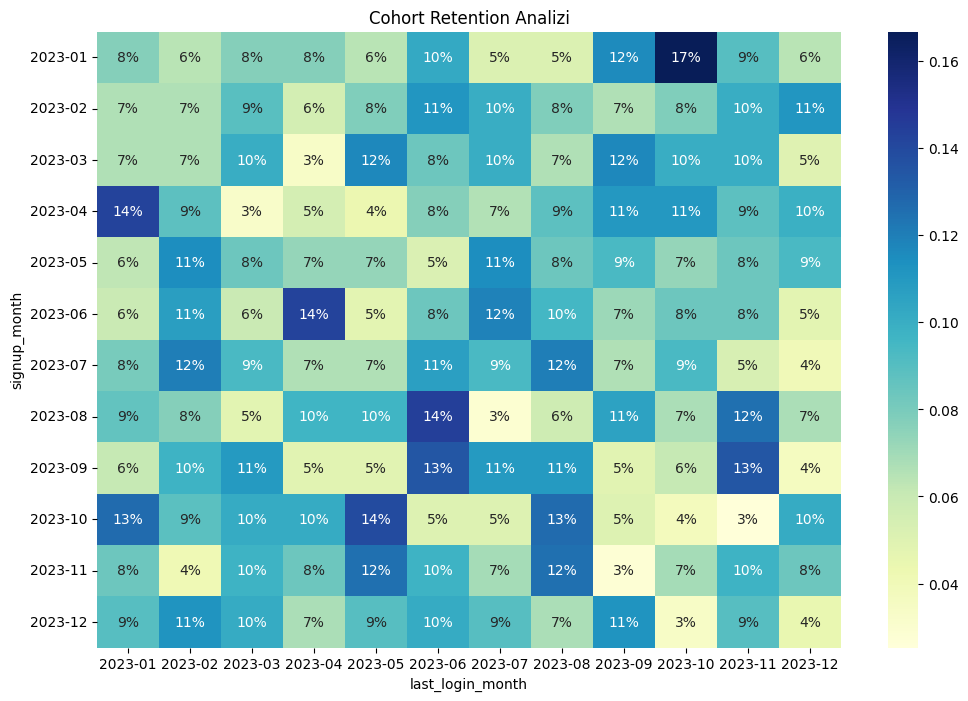

In [ ]:
# Cohort analizi için hazırlık
df['signup_month'] = df['signup_date'].dt.to_period('M')
df['last_login_month'] = df['last_login'].dt.to_period('M')

# Cohort büyüklükleri
cohort_sizes = df.groupby('signup_month')['user_id'].nunique()
print("\nCohort büyüklükleri:")
print(cohort_sizes)

# Retention analizi
cohort_data = df.groupby(['signup_month', 'last_login_month'])['user_id'].nunique().unstack()
cohort_retention = cohort_data.divide(cohort_sizes, axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_retention, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Cohort Retention Analizi')
plt.show()

4. RFM Analizi


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Örnek veri oluşturma (sizin gerçek verinizle değiştirin)
np.random.seed(42)
n_users = 1000
data = {
    'user_id': np.arange(1, n_users+1),
    'last_login': pd.to_datetime('2024-01-01') - pd.to_timedelta(np.random.randint(1, 365, n_users)),
    'purchase_count': np.random.poisson(2, n_users) + 1,  # En az 1 işlem olacak
    'total_spend': np.round(np.random.exponential(50, n_users), 2)
}
df = pd.DataFrame(data)

# RFM hesaplama
current_date = pd.to_datetime('2024-01-01')
rfm = df.groupby('user_id').agg({
    'last_login': lambda x: (current_date - x.max()).days,  # Recency
    'purchase_count': 'sum',  # Frequency (işlem sayısı)
    'total_spend': 'sum'  # Monetary
})
rfm.columns = ['recency', 'frequency', 'monetary']

# RFM skorlama fonksiyonu (hata yönetimli)
def safe_qcut(series, q, labels, method='qcut'):
    try:
        if method == 'qcut':
            return pd.qcut(series, q=q, labels=labels, duplicates='drop')
        else:
            return pd.cut(series, bins=q, labels=labels)
    except:
        # Hata durumunda basit bölme
        return pd.cut(series, bins=len(labels), labels=labels)

# Skorları hesapla
rfm['R'] = safe_qcut(rfm['recency'], 5, [5, 4, 3, 2, 1], 'qcut')  # Recency (en yeni 5)
rfm['F'] = safe_qcut(rfm['frequency'], 5, [1, 2, 3, 4, 5], 'cut')  # Frequency (cut kullanıyoruz)
rfm['M'] = safe_qcut(rfm['monetary'], 5, [1, 2, 3, 4, 5], 'qcut')  # Monetary

# RFM skorunu birleştir
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Segmentasyon haritası
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

# Segmentleri oluştur
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)

# Sonuçları göster
print("RFM Tablosu Önizleme:")
print(rfm.head())

print("\nSegment Dağılımı:")
print(rfm['Segment'].value_counts())

RFM Tablosu Önizleme:
         recency  frequency  monetary  R  F  M RFM_Score         Segment
user_id                                                                 
1              0          4      4.85  3  3  1       331  Need Attention
2              0          5      8.88  3  3  1       331  Need Attention
3              0          5     45.22  3  3  4       334  Need Attention
4              0          3      8.15  3  2  1       321  About to Sleep
5              0          1    172.22  3  1  5       315  About to Sleep

Segment Dağılımı:
Segment
About to Sleep     675
Need Attention     267
Loyal Customers     58
Name: count, dtype: int64


5. LTV Tahmin Modeli


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1. Örnek Veri Oluşturma (Kendi verinizle değiştirin)
np.random.seed(42)
n_users = 1000
current_date = pd.to_datetime('2024-01-01')

data = {
    'user_id': np.arange(1, n_users+1),
    'signup_date': pd.to_datetime('2022-01-01') + pd.to_timedelta(np.random.randint(0, 730, n_users)),
    'last_login': current_date - pd.to_timedelta(np.random.randint(1, 365, n_users)),
    'session_duration_avg': np.random.normal(300, 60, n_users),
    'purchase_count': np.random.poisson(3, n_users) + 1,
    'total_spend': np.round(np.random.exponential(100, n_users), 2),
    'platform': np.random.choice(['iOS', 'Android'], n_users, p=[0.6, 0.4])
}

df = pd.DataFrame(data)

# 2. Özellik Mühendisliği - Gerekli Sütunları Oluşturma
df['days_since_signup'] = (current_date - df['signup_date']).dt.days
df['days_since_last_login'] = (current_date - df['last_login']).dt.days

# 3. LTV Tahmin Modeli için Veri Hazırlığı
features = df[['days_since_signup', 'days_since_last_login',
               'session_duration_avg', 'purchase_count', 'platform']]
target = df['total_spend']

# 4. Veri Ön İşleme
numeric_features = ['days_since_signup', 'days_since_last_login',
                   'session_duration_avg', 'purchase_count']
categorical_features = ['platform']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# 5. Modelleri Tanımlama
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# 6. Veriyi Eğitim ve Test Setlerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

# 7. Model Eğitimi ve Değerlendirme
results = {}
for name, model in models.items():
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {'MAE': mae, 'R2': r2}

        print(f"{name}:")
        print(f"  MAE: {mae:.2f}")
        print(f"  R2: {r2:.2f}")

    except Exception as e:
        print(f"{name} modelinde hata oluştu: {str(e)}")

# 8. En İyi Modeli Seçme
if results:
    best_model_name = min(results, key=lambda x: results[x]['MAE'])
    print(f"\nEn iyi model: {best_model_name}")

    # 9. Özellik Önemlilikleri (XGBoost veya LightGBM için)
    if best_model_name in ['XGBoost', 'LightGBM']:
        try:
            # Özellik isimlerini al
            numeric_feature_names = numeric_features
            categorical_feature_names = list(pipeline.named_steps['preprocessor']
                                          .named_transformers_['cat']
                                          .get_feature_names_out(categorical_features))

            all_feature_names = numeric_feature_names + categorical_feature_names

            # Görselleştirme
            plt.figure(figsize=(10, 6))

            if best_model_name == 'XGBoost':
                pipeline.named_steps['model'].get_booster().feature_names = all_feature_names
                from xgboost import plot_importance
                plot_importance(pipeline.named_steps['model'])
            else:  # LightGBM
                lgbm_importances = pd.Series(
                    pipeline.named_steps['model'].feature_importances_,
                    index=all_feature_names
                ).sort_values(ascending=False)
                sns.barplot(x=lgbm_importances, y=lgbm_importances.index)
                plt.xlabel('Özellik Önem Skoru')

            plt.title(f'{best_model_name} - Özellik Önemlilikleri')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Özellik önemlilik grafiği oluşturulurken hata: {str(e)}")
else:
    print("Hiçbir model başarıyla çalıştırılamadı.")

Linear Regression:
  MAE: 70.47
  R2: -0.00
XGBoost:
  MAE: 92.63
  R2: -1.03
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 4
[LightGBM] [Info] Start training from score 97.658812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


6. Sonuçların Değerlendirilmesi



Model Performans Karşılaştırması:
                         MAE        R2
Linear Regression  70.471038 -0.001492
XGBoost            92.625171 -1.030961
LightGBM           79.756888 -0.247891


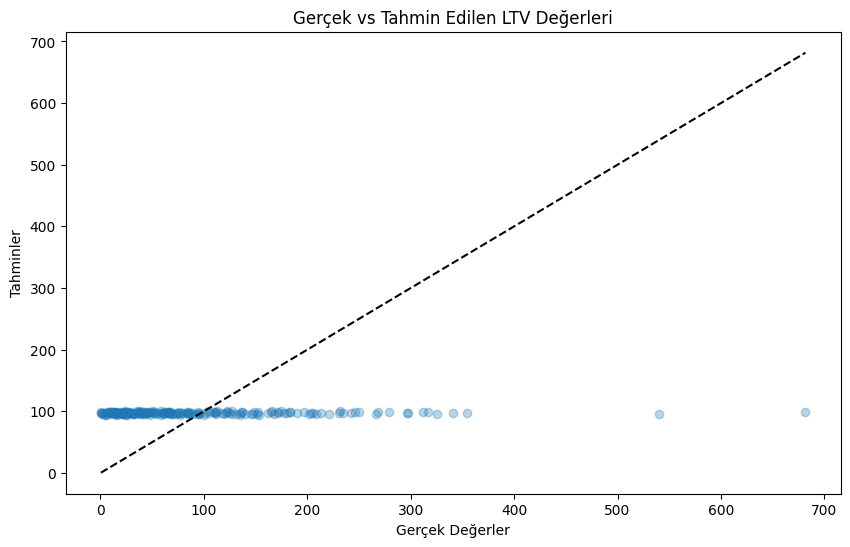

In [ ]:
# Model karşılaştırması
results_df = pd.DataFrame(results).T
print("\nModel Performans Karşılaştırması:")
print(results_df)

# Gerçek vs Tahmin görselleştirme
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Gerçek vs Tahmin Edilen LTV Değerleri')
plt.show()